In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import kagglehub
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download reduced MNIST via KaggleHub
path = kagglehub.dataset_download("mohamedgamal07/reduced-mnist")
root = os.path.join(path, "Reduced MNIST Data")
# Note: the training folder in this dataset uses a typo in its name
train_folder = os.path.join(root, "Reduced Trainging data")  # intentional: matches Kaggle folder
test_folder  = os.path.join(root, "Reduced Testing data")

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),                # outputs [0,1]
    transforms.Normalize((0.5,), (0.5,)), # -> [-1,1]
])

In [5]:
full_train = ImageFolder(train_folder, transform=transform)
test_ds    = ImageFolder(test_folder, transform=transform)

In [6]:
train_size = int(0.9 * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

In [7]:
LATENT_DIM = 100
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 7*7*256, bias=False),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256,7,7)),
            nn.ConvTranspose2d(256,128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128,64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),  nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64,1,   kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Conv2d(64,128,kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3),
            nn.Flatten(), nn.Linear(128*7*7,1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

In [8]:
digits_data = {d: [] for d in range(10)}
for digit in range(10):
    idxs  = [i for i, (_, lbl) in enumerate(full_train) if lbl == digit]
    ds    = Subset(full_train, idxs)
    loader= DataLoader(ds, batch_size=256, shuffle=True)

    G = Generator(LATENT_DIM).to(device)
    D = Discriminator().to(device)
    optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
    optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
    criterion = nn.BCELoss()

    real_count = len(ds)
    gen_counts = [1000,2000,3000] if real_count == 300 else [1000,1000,3000]

    for epoch in range(50):
        for real_imgs, _ in loader:
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            real_lbl = torch.full((bs,1), 0.9, device=device)
            fake_lbl = torch.zeros((bs,1), device=device)

            # Discriminator step
            optD.zero_grad()
            loss_real = criterion(D(real_imgs), real_lbl)
            z = torch.randn(bs, LATENT_DIM, device=device)
            fake = G(z)
            loss_fake= criterion(D(fake.detach()), fake_lbl)
            (loss_real + loss_fake).backward(); optD.step()

            # Generator step
            optG.zero_grad()
            loss_g = criterion(D(fake), torch.ones_like(fake_lbl))
            loss_g.backward(); optG.step()

    with torch.no_grad():
        for cnt in gen_counts:
            z = torch.randn(cnt, LATENT_DIM, device=device)
            digits_data[digit].append(G(z).cpu())


In [10]:
scenarios = [
    {"real":300,"gen":0,   "name":"300_real"},
    {"real":300,"gen":1000,"name":"300_real_1000_gen"},
    {"real":300,"gen":2000,"name":"300_real_2000_gen"},
    {"real":300,"gen":3000,"name":"300_real_3000_gen"},
    {"real":700,"gen":0,   "name":"700_real"},
    {"real":700,"gen":1000,"name":"700_real_1000_gen"},
    {"real":700,"gen":2000,"name":"700_real_2000_gen"},
    {"real":700,"gen":3000,"name":"700_real_3000_gen"},
    {"real":1000,"gen":0,  "name":"1000_real"},
    {"real":1000,"gen":1000,"name":"1000_real_1000_gen"},
    {"real":1000,"gen":2000,"name":"1000_real_2000_gen"},
    {"real":1000,"gen":3000,"name":"1000_real_3000_gen"}
]
experiment_datasets = {}
for sc in scenarios:
    X, y = [], []
    for d in range(10):
        real_idxs = [i for i, (_, lbl) in enumerate(full_train) if lbl == d][:sc["real"]]
        for i in real_idxs:
            img, _ = full_train[i]; X.append(img); y.append(d)
        if sc["gen"]>0:
            syn = digits_data[d][0 if sc["gen"]==1000 else (1 if sc["gen"]==2000 else 2)]
            for img in syn[:sc["gen"]]: X.append(img); y.append(d)
    experiment_datasets[sc["name"]] = TensorDataset(torch.stack(X), torch.tensor(y))


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64*5*5,128), nn.ReLU(), nn.Linear(128,10)
        )
    def forward(self, x): return self.net(x)

train_accs, test_accs, names = [], [], []
test_loader = DataLoader(test_ds, batch_size=64)
for name, ds in experiment_datasets.items():
    loader = DataLoader(ds, batch_size=64, shuffle=True)
    model = CNN().to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit  = nn.CrossEntropyLoss()
    for _ in range(5):
        model.train()
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
    model.eval()
    def eval_dl(dl):
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                preds= model(xb).argmax(1)
                correct += (preds == yb).sum().item(); total += yb.size(0)
        return correct/total
    tr_acc = eval_dl(loader)
    te_acc = eval_dl(test_loader)
    print(f"{name:25s} → Train: {tr_acc:.4f} | Test: {te_acc:.4f}")
    train_accs.append(tr_acc); test_accs.append(te_acc); names.append(name)

300_real                  → Train: 0.9773 | Test: 0.9680
300_real_1000_gen         → Train: 0.9968 | Test: 0.9665
300_real_2000_gen         → Train: 0.9954 | Test: 0.9625
300_real_3000_gen         → Train: 0.9992 | Test: 0.9690
700_real                  → Train: 0.9894 | Test: 0.9820
700_real_1000_gen         → Train: 0.9958 | Test: 0.9775
700_real_2000_gen         → Train: 0.9955 | Test: 0.9795
700_real_3000_gen         → Train: 0.9989 | Test: 0.9710
1000_real                 → Train: 0.9904 | Test: 0.9780
1000_real_1000_gen        → Train: 0.9968 | Test: 0.9785
1000_real_2000_gen        → Train: 0.9946 | Test: 0.9790
1000_real_3000_gen        → Train: 0.9960 | Test: 0.9785


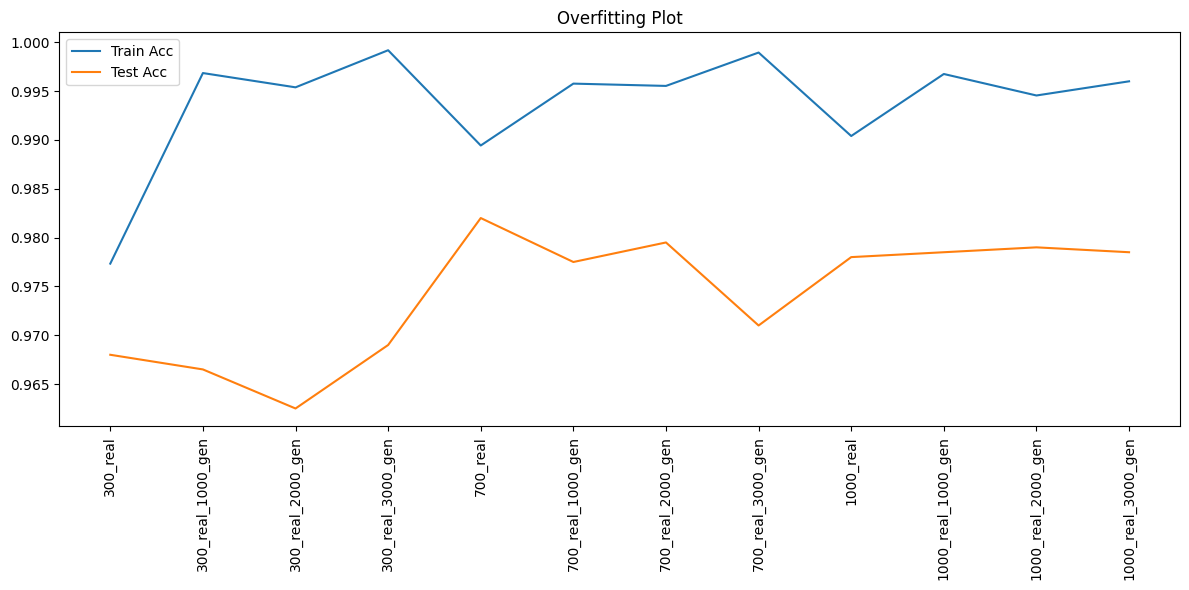

In [12]:
plt.figure(figsize=(12,6))
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs,  label='Test Acc')
plt.xticks(range(len(names)), names, rotation=90)
plt.title('Overfitting Plot')
plt.legend(); plt.tight_layout(); plt.show()

In [23]:
def show_synthetic(digit, gen_idx=0, n_samples=10):
    """
    Plot n_samples from synthetic batch gen_idx for a given digit.
    gen_idx=0→first batch (1000),1→second(2000),2→third(3000).
    """
    imgs = digits_data[digit][gen_idx]
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples,1))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Synthetic samples for digit {digit} (batch {gen_idx})")
    plt.show()

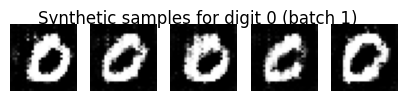

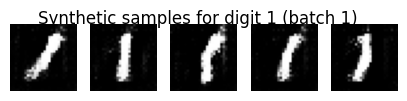

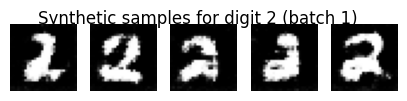

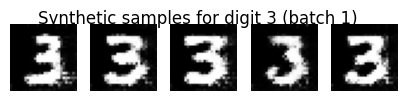

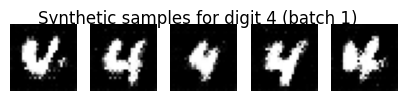

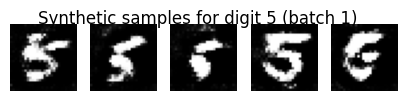

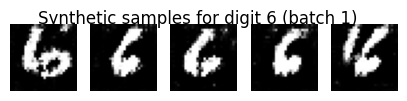

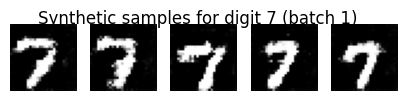

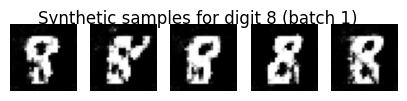

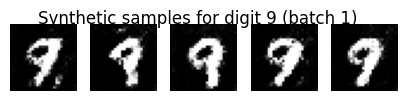

In [28]:
for i in range(10):
    show_synthetic(digit=i, gen_idx=1, n_samples=5)
    print()

In [29]:
results = dict(zip(names, test_accs))

best_name, best_acc = max(
    ((n, results[n]) for n in names if n.startswith("300_real")),
    key=lambda x: x[1]
)

baseline_acc = results["1000_real"]

print(f"\nBest augmentation with 300 real: {best_name} → Test Acc = {best_acc:.4f}")
print(f"Baseline 1000_real → Test Acc = {baseline_acc:.4f}")
print(f"Using {best_name.split('_')[0]} real + synthetic achieves {best_acc / baseline_acc * 100:.2f}% of the 1000-real baseline.")



Best augmentation with 300 real: 300_real_3000_gen → Test Acc = 0.9690
Baseline 1000_real → Test Acc = 0.9780
Using 300 real + synthetic achieves 99.08% of the 1000-real baseline.


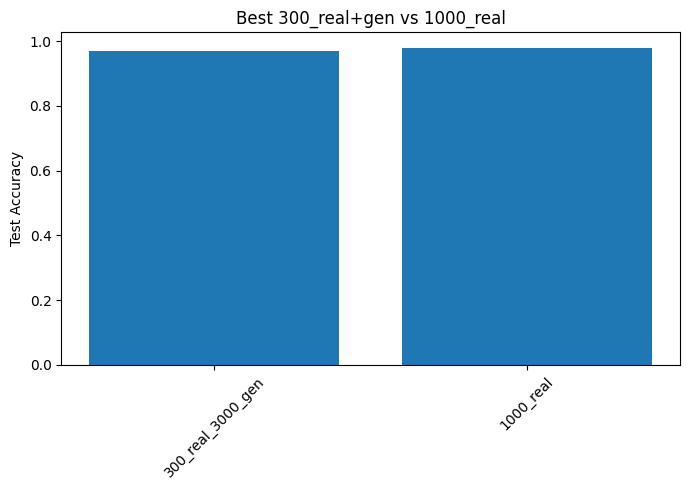

In [31]:
plt.figure(figsize=(7, 5))
plt.bar([best_name, "1000_real"], [best_acc, baseline_acc])
plt.ylabel("Test Accuracy")
plt.title("Best 300_real+gen vs 1000_real")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()